In [14]:
from scipy.special import expit
from rbmpy.rbm import RBM
from rbmpy.sampler import VanillaSampler, PartitionedSampler, ApproximatedSampler, LayerWiseApproxSampler,ApproximatedMulDimSampler
from rbmpy.trainer import VanillaTrainier
from rbmpy.performance import Result
import numpy as np
import rbmpy.datasets, rbmpy.performance, rbmpy.plotter, pickle, rbmpy.rbm, os, logging, rbmpy.sampler,math

from rbmpy.rbm import weights_into_hiddens

import rbmpy.plotter as pp
from numpy import newaxis
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)


%matplotlib inline
from IPython.core.debugger import Tracer; debug_here = Tracer()
# Helper Methods
def squash_images(imgs):
    squashed = np.array(imgs)
    old_shape = squashed.shape
    squashed = squashed.reshape(old_shape[0], old_shape[1] * old_shape[2])
    return squashed

def inflate_images(imgs):
    inflated = np.array(imgs)
    old_shape = inflated.shape
    size= math.sqrt(old_shape[1])
    inflated = inflated.reshape(old_shape[0], size, size)
    return inflated

def gen_square(xy,sq_shape, img_size):
    """Square image starting at i, of sq_size within img_size. i must be < (sq_size + img_size)"""
    img = np.zeros(img_size)
    x = xy[0]
    y = xy[1]
    x2 = x + sq_shape[0]
    y2 = y + sq_shape[1]
    img[x:x2,y:y2] = 1
    return img

def gen_training(sq_shape, img_size):
    if img_size[0] != img_size[1]:
        logger.warn("Unsquashing will not work with none squares yet!")
    training = []
    for x in range(img_size[0]-(sq_shape[0]-1)):
        for y in range(img_size[1] - (sq_shape[1]-1)):
            training.append(gen_square((x,y), sq_shape, img_size))
    return np.array(training)
    
def ll_score(v, v_prime):
    if v == 1:
        return np.log(v_prime)
    elif v == 0:
        return np.log(1 - v_prime)
    else:
        raise NotImplementedError()
ll_score = np.vectorize(ll_score)

def evaluate_model(training, model):
    s = VanillaSampler(model)
    results = []
    avg = 0
    for i in range(5000):
        results.append(ll_score(squash_images(training),s.reconstruction_given_visible(squash_images(training), return_sigmoid=True)).sum())
    avg = avg/i
    npr = np.array(results)
    return npr
   # return np.median(npr,axis=0), np.min(npr, axis = 0), np.max(npr,axis = 0), np.mean(npr,axis = 0)
    
    
def plot_eval(train,model):
    # look at the reconstructions
    dreams = []
    for i in range(16):
        dreams.append(s.dream(model).reshape(5,5))
    pp.images(np.array(dreams))
    # Lets also look at it's weights
    pp.images(weights_into_hiddens(model.weights)[:10], cmap='Greys',title= "Hinton Diagrams",filename="Results/Weights.png")
    result = evaluate_model(train,model)
    plt.plot(result)
    plt.show()
    print("mean{:.2f} Worst {:.2f} Best {:.2f}".format( np.mean(result), np.min(result), np.max(result)))
    pp.images(inflate_images(squash_images(train) - s.reconstruction_given_visible(squash_images(train))))

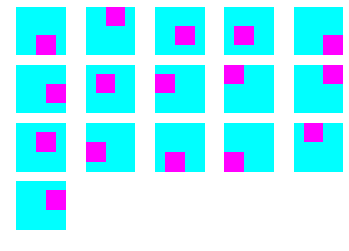

In [15]:
train_sq = gen_training((2,2),(5,5))
np.random.shuffle(train_sq)
pp.images(train_sq, title="Training Set")

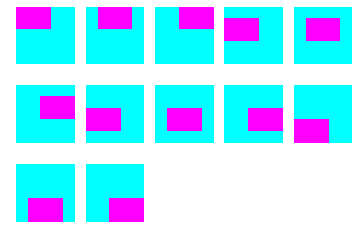

In [16]:
train_rect = gen_training((2,3),(5,5))
# np.random.shuffle(train_rect)
pp.images(train_rect, title="Training Set")

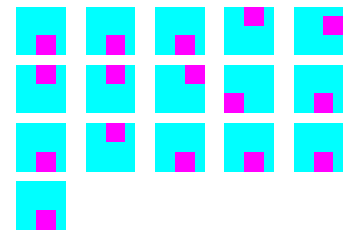

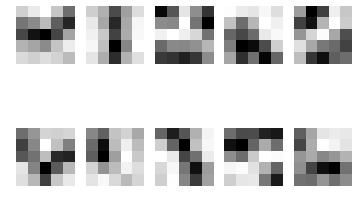

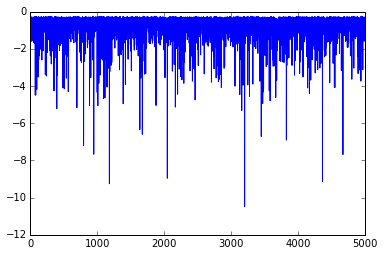

mean-0.81 Worst -10.48 Best -0.24


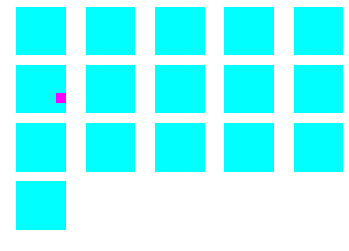

In [17]:
sq_model = RBM(25,25,train_sq.shape[0])
s = VanillaSampler(sq_model)
t = VanillaTrainier(sq_model, s)
t.train(10000, squash_images(train_sq), learning_rate=0.005)
# plot the 16 centers
plot_eval(train_sq, sq_model)

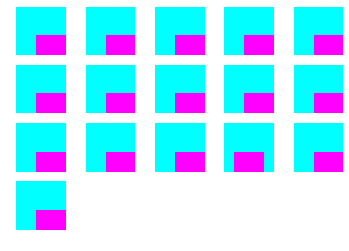

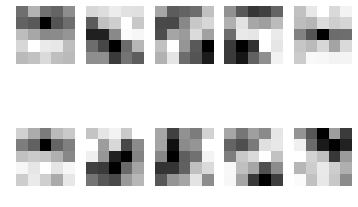

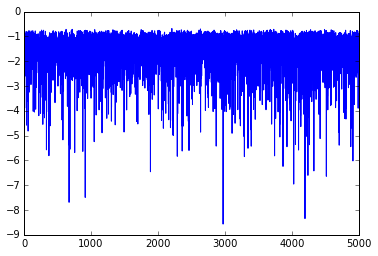

mean-1.63 Worst -8.57 Best -0.68


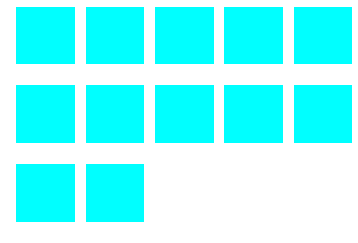

In [18]:
rect_model = RBM(25,25,train_sq.shape[0])
s = VanillaSampler(rect_model)
t = VanillaTrainier(rect_model, s)
t.train(10000, squash_images(train_rect), learning_rate=0.005)
# plot the 16 centers
plot_eval(train_rect, rect_model)

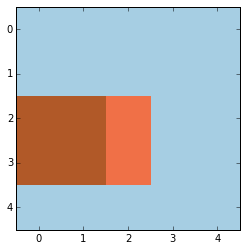

In [19]:
data_sq = sq_model.visible.copy()
data_rect = rect_model .visible.copy()
np.random.shuffle(data_sq)
np.random.shuffle(data_rect)
item_one = inflate_images(data_sq)[0]
item_two = inflate_images(data_rect)[1]
composite_v = np.maximum(item_one ,item_two)
pp.image(item_one+ item_two,cmap='Paired',show_colorbar=False)

In [20]:
rand_h = rbm.random_hidden_for_rbm(sq_model)

approx= ApproximatedSampler(sq_model.weights, rect_model.weights, sq_model.hidden_bias, rect_model.hidden_bias)
reconstruction = approx.v_to_v(rand_h,rand_h, composite_v.reshape(25),num_gibbs=3500)
pp.image(reconstruction[0].reshape(5,5),show_colorbar=False, title="V'_a")
pp.image(reconstruction[1].reshape(5,5), show_colorbar=False, title = "V'_b" )
pp.image(reconstruction[0].reshape(5,5) + reconstruction[1].reshape(5,5),title="Composite Recon" ,cmap ='Paired',show_colorbar=False)
pp.image(s.reconstruction_given_visible(composite_v.reshape(25)).reshape(5,5),show_colorbar=False)

NameError: name 'rbm' is not defined

In [ ]:
def do_it(train_one, train_two):
    model_one = RBM(25,25,train_one.shape[0])
    s = VanillaSampler(model_one)
    t = VanillaTrainier(model_one, s)
    t.train(10000, squash_images(train_one), learning_rate=0.005)

    model_two = RBM(25,25,train_two.shape[0])
    s = VanillaSampler(model_two)
    t = VanillaTrainier(model_two, s)
    t.train(10000, squash_images(train_two), learning_rate=0.005)

    data_sq = model_one.visible.copy()
    data_rect = model_two.visible.copy()
    np.random.shuffle(data_sq)
    np.random.shuffle(data_rect)
    item_one = inflate_images(data_sq)[0]
    item_two = inflate_images(data_rect)[1]
    composite_v = np.maximum(item_one ,item_two)
    pp.image(item_one+ item_two,cmap='Paired',show_colorbar=False)
    
    rand_h = rbm.random_hidden_for_rbm(model_one)

    approx= ApproximatedSampler(model_one.weights, model_two.weights, model_one.hidden_bias, model_two.hidden_bias)
    reconstruction = approx.v_to_v(rand_h,rand_h, composite_v.reshape(25),num_gibbs=3500)
    pp.image(reconstruction[0].reshape(5,5),show_colorbar=False, title="V'_a")
    pp.image(reconstruction[1].reshape(5,5), show_colorbar=False, title = "V'_b" )
    pp.image(reconstruction[0].reshape(5,5) + reconstruction[1].reshape(5,5),title="Composite Recon" ,cmap ='Paired',show_colorbar=False)
    pp.image(s.reconstruction_given_visible(composite_v.reshape(25)).reshape(5,5),show_colorbar=False)

In [ ]:
do_it(train_sq,train_rect)

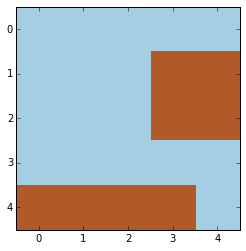

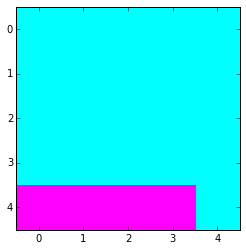

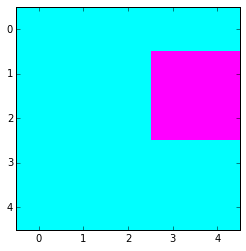

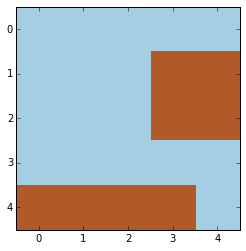

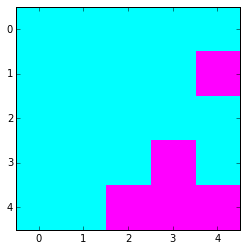

In [33]:
do_it(gen_training((1,4),(5,5)),gen_training((2,2),(5,5)))

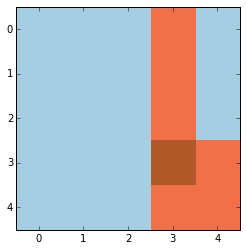

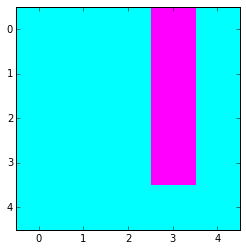

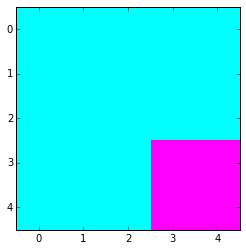

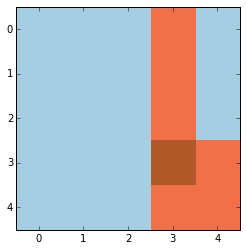

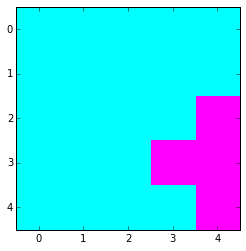

In [34]:
do_it(gen_training((4,1),(5,5)),gen_training((2,2),(5,5)))

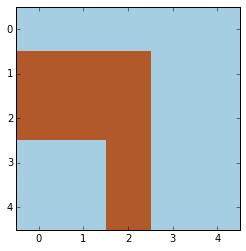

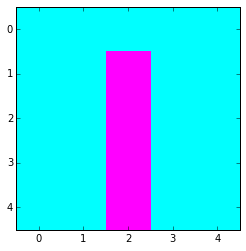

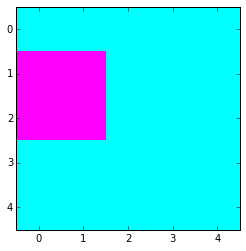

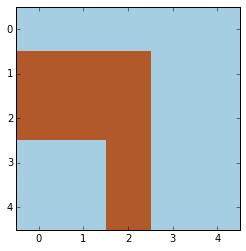

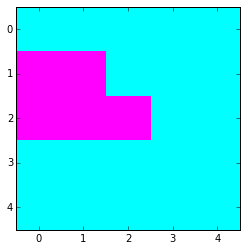

In [8]:
do_it(gen_training((4,1),(5,5)),gen_training((2,2),(5,5)))

In [2]:
def train(training):
    model = RBM(25,25,training.shape[0])
    s = VanillaSampler(model)
    t = VanillaTrainier(model, s)
    t.train(10000, squash_images(training), learning_rate=0.005)
    return model

def composite_train(static,dynamic):
    comp = []
    for i in range(dynamic.shape[0]):
        comp.append(np.maximum(static, dynamic[i]))
        
    return comp

def do_it_all():
    img_size = 5
    train_one = gen_training((2,2),(img_size,img_size))
    model_one = train(train_one)
    s1 = VanillaSampler(model_one)
    for i in range(2,img_size):
        for j in range(3,img_size):
            train_two = gen_training((i, j), (img_size, img_size))
            model_two = train(train_two)
            rand_h = rbm.random_hidden_for_rbm(model_two)
            approx = ApproximatedSampler(model_one.weights, model_two.weights, model_one.hidden_bias, model_two.hidden_bias)
            comp = composite_train(train_one[0], train_two)

            for current_img in comp:
                reconstruction = approx.v_to_v(rand_h,rand_h,current_img.reshape(25),num_gibbs=1000)
                pp.images(np.array([current_img,reconstruction[0].reshape(5,5), reconstruction[1].reshape(5,5), s1.reconstruction_given_visible(current_img.reshape(25)).reshape(5,5)]))
            print("finished pass")
            

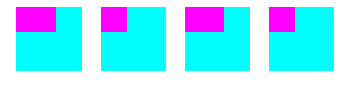

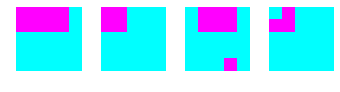

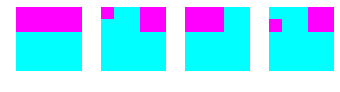

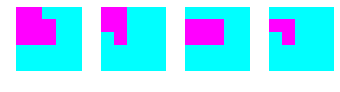

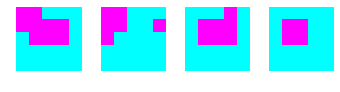

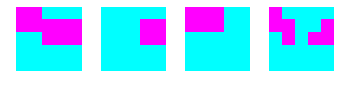

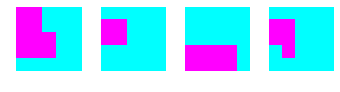

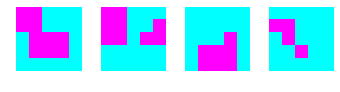

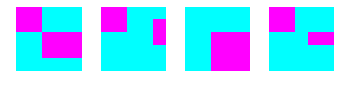

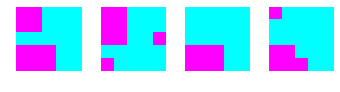

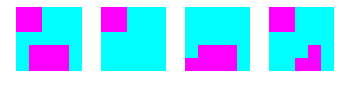

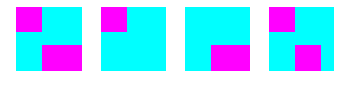

finished pass


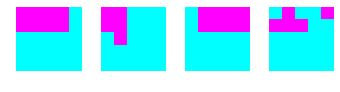

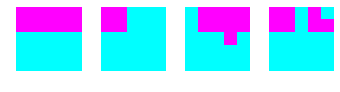

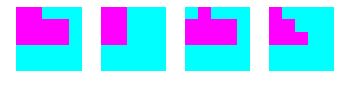

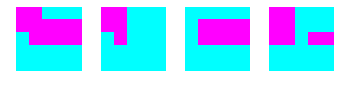

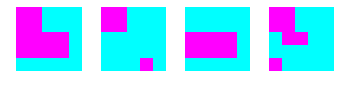

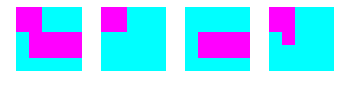

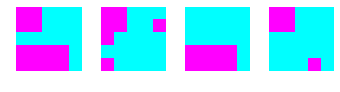

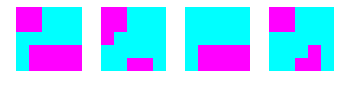

finished pass


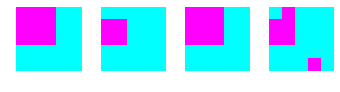

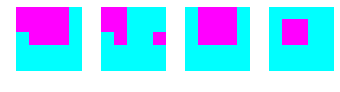

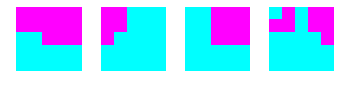

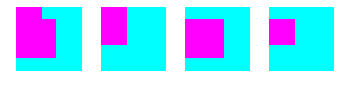

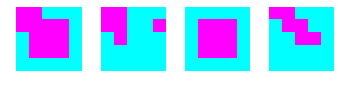

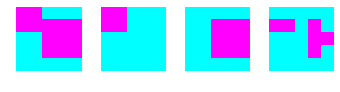

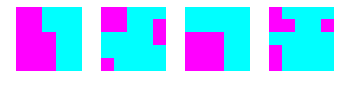

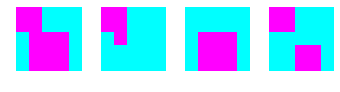

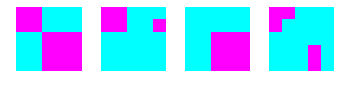

finished pass


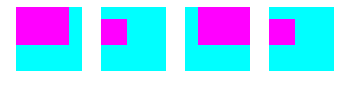

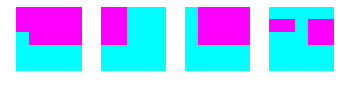

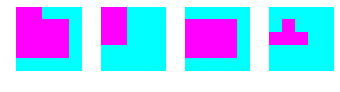

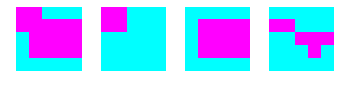

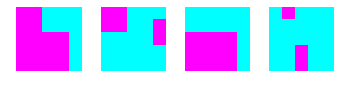

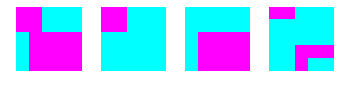

finished pass


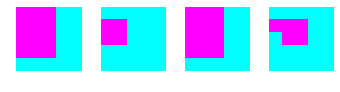

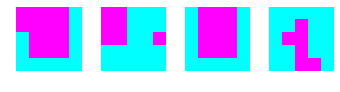

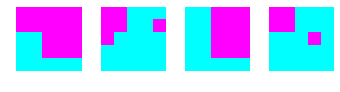

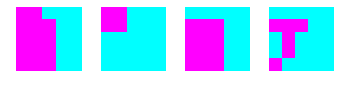

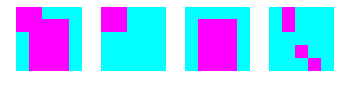

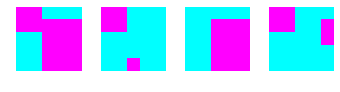

finished pass


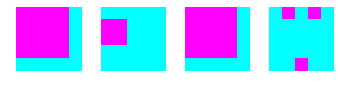

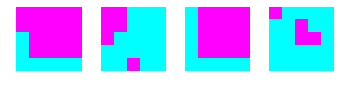

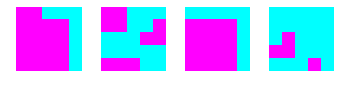

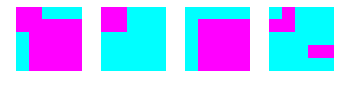

finished pass


In [18]:
do_it_all()